In [1]:
import tensorflow as tf
import datetime
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras import models
from tensorflow.keras.models import Model 
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os, shutil
#from PIL import Image, ImageDraw, ImageFont, ImageColor
import random 
import pandas as pd
import pydot

In [6]:
train_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_23' 
#test_dataset_dir='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Testing_set_6_18' 

df=pd.read_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"))
df = df.sample(frac=1,random_state=5).reset_index(drop=True)
#df = df.sample(frac=0.5,random_state=5).reset_index(drop=True)
# df['x_coord']=df['x_coord'].apply(lambda x:[x])
# df['y_coord']=df['y_coord'].apply(lambda x:[x])
# df['neighbor1x']=df['neighbor1x'].apply(lambda x:[x])
# df['neighbor1y']=df['neighbor1y'].apply(lambda x:[x])
# df['neighbor2x']=df['neighbor2x'].apply(lambda x:[x])
# df['neighbor2y']=df['neighbor2y'].apply(lambda x:[x])
# df['neighbor3x']=df['neighbor3x'].apply(lambda x:[x])
# df['neighbor3y']=df['neighbor3y'].apply(lambda x:[x])


# dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
# dft = dft.sample(frac=1,random_state=5).reset_index(drop=True)

df.shape
#dft.shape


(300000, 17)

In [7]:
def build_model():
    model = models.Sequential()                                  
    model.add(layers.Conv2D(32, (3,3) ,activation='relu', input_shape=(32,32,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8))
    return model

def get_compiled_model():
    model=build_model()
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
    return model

In [8]:
# def build_model():
#     input_img= Input(shape=(32,32,3))
#     conv_1= Conv2D(32, (3,3) ,activation='relu')(input_img)
#     pool_1= MaxPooling2D((2,2))(conv_1)
#     conv_2= Conv2D(64,(3,3), activation='relu')(pool_1)
#     pool_2= MaxPooling2D((2,2))(conv_2)
#     conv_3= Conv2D(64,(3,3), activation='relu')(pool_2)
#     pool_3= MaxPooling2D((2,2))(conv_3)
#     dropout_1= Dropout(0.5)(pool_3)
#     flatten_1= Flatten()(dropout_1)
#     dense_1= Dense(128, activation='relu')(flatten_1)
#     dense_2= Dense(64, activation='relu')(dense_1)

#     out_1= Dense(1,name='x_coord')(dense_2)
#     out_2= Dense(1,name='y_coord')(dense_2)
#     out_3= Dense(1,name='neighbor1x')(dense_2)
#     out_4= Dense(1,name='neighbor1y')(dense_2)
#     out_5= Dense(1,name='neighbor2x')(dense_2)
#     out_6= Dense(1,name='neighbor2y')(dense_2)
#     out_7= Dense(1,name='neighbor3x')(dense_2)
#     out_8= Dense(1,name='neighbor3y')(dense_2)

#     combined_outputs=layers.concatenate([out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8],name='outputs')


#     #model=Model(inputs=input_img,outputs=[out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8])
#     model=Model(inputs=input_img,outputs=combined_outputs)
#     return model

# def get_compiled_model():
#     model=build_model()
#     def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))
#     model.compile(
#     optimizer='Adam',
#     loss={'x_coord':root_mean_squared_error, 'y_coord':root_mean_squared_error,
#         'neighbor1x':root_mean_squared_error,'neighbor1y':root_mean_squared_error,
#         'neighbor2x':root_mean_squared_error,'neighbor2y':root_mean_squared_error,
#         'neighbor3x':root_mean_squared_error,'neighbor3y':root_mean_squared_error},
#     loss_weights={'x_coord':1,'y_coord':1,
#         'neighbor1x':1,'neighbor1y':1,
#         'neighbor2x':1,'neighbor2y':1,
#         'neighbor3x':1,'neighbor3y':1},
#     metrics={"x_coord":['mse','mae'],'y_coord':['mse','mae'],
#         'neighbor1x':['mse','mae'],'neighbor1y':['mse','mae'],
#         'neighbor2x':['mse','mae'],'neighbor2y':['mse','mae'],
#         'neighbor3x':['mse','mae'],'neighbor3y':['mse','mae']}
#     )
#     return model

# def get_compiled_model():
#     model=build_model()
#     model.compile(optimizer='Adam', loss=tf.keras.metrics.RootMeanSquaredError(), metrics=['mse','mae'])
#     return model

model=build_model()
model.summary()
#plot_model(model,show_shapes=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 64)          0

In [9]:
SEED=5
model=get_compiled_model()
index=0

predict_test_datagen=ImageDataGenerator(rescale=1./255)
predict_test_generator=predict_test_datagen.flow_from_dataframe(
    df,
    directory=test_dataset_dir,
    x_col="filename",
    target_size=(32,32),
    shuffle=True,
    seed= SEED,
    class_mode=None,
    batch_size=30
    )

prediction=model.predict(predict_test_generator,verbose=1)
print(prediction)

Found 90 validated image filenames.
3/3 [==============================] - 33s 11s/step
[[ 0.0347379   0.10636668  0.22455525 -0.01030042  0.03449146  0.05670094
  -0.18938929 -0.0697066 ]
 [ 0.05079336  0.09454001  0.22753386 -0.02849666  0.06073937  0.03750228
  -0.18995568 -0.05215186]
 [ 0.04864574  0.09091143  0.22625448 -0.0205521   0.05663506  0.03672906
  -0.18337758 -0.05711602]
 [ 0.05170155  0.08903003  0.23294912 -0.01927556  0.04819425  0.04070905
  -0.19495162 -0.06729934]
 [ 0.03777979  0.096786    0.22007807 -0.02373006  0.04636058  0.03843426
  -0.18188071 -0.05481575]
 [ 0.05418783  0.09851358  0.2449151  -0.01757863  0.05145222  0.04396151
  -0.20612791 -0.05110384]
 [ 0.03907435  0.10907285  0.22147238 -0.03000969  0.05008761  0.05798037
  -0.18410939 -0.06059301]
 [ 0.02574161  0.11729321  0.20980681 -0.00765834  0.03452306  0.06122296
  -0.18820727 -0.06164143]
 [ 0.03115281  0.11252534  0.22885714 -0.02331484  0.05199206  0.04124324
  -0.18126851 -0.07457791]
 [ 

In [9]:
#Creates generators for training and validation images
SEED=5
validation_split_frac=0.2
batch_size=256
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split_frac)
test_datagen = ImageDataGenerator(rescale=1./255)  
train_generator= train_datagen.flow_from_dataframe(
        df,
        directory=train_dataset_dir,
        x_col="filename",
        y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
        target_size=(32,32),
        shuffle=True,
        color_mode='rgb',
        seed= SEED,
        class_mode="raw",
        batch_size=batch_size,
        subset='training')

validation_generator= train_datagen.flow_from_dataframe(
        df,
        directory=train_dataset_dir,
        x_col="filename",
        y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
        target_size=(32,32),
        shuffle=True,
        color_mode='rgb',
        seed= SEED,
        class_mode="raw",
        batch_size=batch_size,
        subset='validation')


# def generator_multiout(generator):
#         while True:
#                 Im, labels=generator.next()
#                 label_0=[]
#                 label_1=[]
#                 label_2=[]
#                 label_3=[]
#                 label_4=[]
#                 label_5=[]
#                 label_6=[]
#                 label_7=[]
#                 for label in labels:
#                         label_0.append(label[0])
#                         label_1.append(label[1])
#                         label_2.append(label[2])
#                         label_3.append(label[3])
#                         label_4.append(label[4])
#                         label_5.append(label[5])
#                         label_6.append(label[6])
#                         label_7.append(label[7])
#                 yield Im, {'x_coord':label_0,'y_coord':label_1,'neighbor1x':label_2,'neighbor1y':label_3,'neighbor2x':label_4,'neighbor2y':label_5,'neighbor3x':label_6,'neighbor3y':label_7}


# test_generator= test_datagen.flow_from_dataframe(
#         dft,
#         directory=test_dataset_dir,
#         x_col="filename",
#         y_col=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y'],
#         target_size=(32,32),
#         shuffle=True,
#         seed= SEED,
#         class_mode="raw",
#         batch_size=batch_size)

Found 240000 validated image filenames.
Found 60000 validated image filenames.


data batch shape: (256, 32, 32, 3)


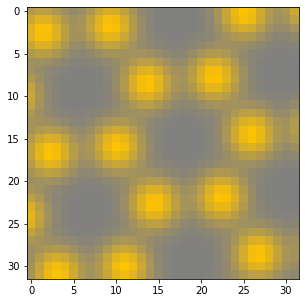

In [95]:
# for data_batch, labels_batch in generator_multiout(train_generator):
#     print('data batch shape:', data_batch.shape)
#     #print('labels batch shape:', labels_batch.shape)
#     plt.figure(figsize = (5, 5))
#     ax = plt.subplot(1,1,1)
#     ax.imshow(data_batch[1])
#     #print(labels_batch)
#     break

In [10]:
model_name='run6_24_newdataset'
model=get_compiled_model()
#model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
num_epochs=100
training_steps=int(df.shape[0]*(1-validation_split_frac)/batch_size)
validation_steps=int(df.shape[0]*validation_split_frac/batch_size)
# log_dir = os.path.join("Training_logs\\fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
my_callbacks=[ 
   callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True),
   callbacks.ModelCheckpoint(filepath=os.path.join("Model_Checkpoints",model_name),monitor="val_loss",save_best_only=True)
]
history=model.fit(
    train_generator,
    steps_per_epoch=training_steps,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=num_epochs,
    verbose=1,
    callbacks= my_callbacks
    )

model.save(os.path.join('Models',model_name))
hist_df = pd.DataFrame(history.history) 
hist_csv_file = os.path.join('Model_histories',model_name + '_history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 937 steps, validate for 234 steps
Epoch 1/100
936/937 [============================>.] - ETA: 0s - loss: 0.0525 - mse: 0.0040 - mae: 0.0336WARNING:tensorflow:From D:\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Model_Checkpoints\run6_24_newdataset\assets
937/937 [==============================] - 163s 174ms/step - loss: 0.0525 - mse: 0.0040 - mae: 0.0336 - val_loss: 0.0294 - val_mse: 8.8908e-04 - val_mae: 0.0132
Epoch 2/100
937/937 [==============================] - 129s 138ms/step - loss: 0.0303 - mse: 9.6049e-04 - mae: 0.0135 - val_loss: 0.0268 - val_mse: 7.5382e-04 - val_mae: 0.0111
Epoch 3/100
937

In [11]:
model_name='run6_24_newdataset'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
history_dict=pd.read_csv(os.path.join('Model_histories',model_name + '_history.csv'))

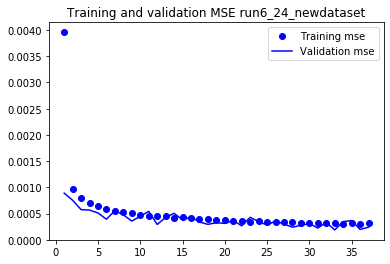

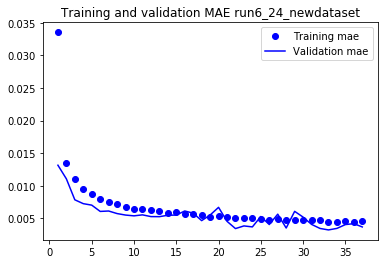

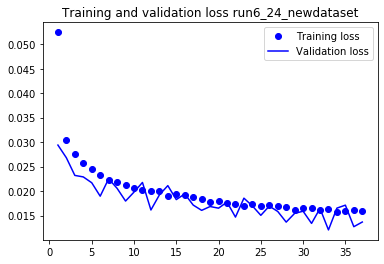

In [12]:
mse = history_dict['mse']
val_mse = history_dict['val_mse']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
# rmse1 = history_dict['rmse_1']
# val_rmse1 = history_dict['val_rmse_1']

epochs = range(1, len(mse) + 1)
os.makedirs(os.path.join('History_Plots',model_name))
plot_dir=os.path.join('History_Plots',model_name)

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation MSE '+ model_name)
plt.legend()
plt.savefig(os.path.join(plot_dir,model_name+" mse.png"))
plt.figure()

# plt.plot(epochs, rmse1, 'bo', label='Training rmse1')
# plt.plot(epochs, val_rmse1, 'b', label='Validation rmse1')
# plt.title('Training and validation RMSE_1 '+ model_name)
# plt.legend()
# plt.savefig(os.path.join(plot_dir,model_name+" rmse1.png"))
# plt.figure()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation MAE '+ model_name)
plt.legend()
plt.savefig(os.path.join(plot_dir,model_name+" mae.png"))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss '+ model_name)
plt.legend()
plt.savefig(os.path.join(plot_dir,model_name+" loss.png"))

plt.show()

In [114]:
#Evaluates the model on testing set
#testing_steps=df.shape[0]//batch_size
model.evaluate(
    predict_test_generator,
    steps=3
)

1/3 [=========>....................] - ETA: 0s

IndexError: tuple index out of range

On the scale of two dimensional materials, stretching or straining the atomic lattice can have an enormous impact on the material properties of whatever you're working with. We can take photos of these materials with atomic resoution, however, the exact distribution of these atoms is hard to characterize by eye, and small strain of 1-2% is almost impossible to distinguish at first glance. My project is to design a machine learning model that can automaticaly detect the strain of a honeycomb lattice, even when that strain is small and varrying across an image. This would allow researchers to compare the strain of a material to its electronic properties and other observables, unveiling connections we haven't been able to see before. Many 2D materials are poorly understood, and this project could help answer many questions about how 2D phenomenon arise.